## 9.1 Siamese BERT-networks for semantic searching

In [115]:
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import numpy as np
from datasets import load_dataset

from sentence_transformers import SentenceTransformer, util
from transformers import pipeline

from random import sample, seed, shuffle
from sentence_transformers import InputExample, losses, evaluation
from torch.utils.data import DataLoader

In [117]:
PERSON = 'Sinan Ozdemir'

# Note this is NOT an efficient way to search on google. This is done simply for education purposes
google_html = BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}').text).get_text()[:1024]

nlp = pipeline('question-answering', 
               model='deepset/roberta-base-squad2', 
               tokenizer='deepset/roberta-base-squad2', 
               max_length=10)

nlp(f'Who is {PERSON}?', google_html)

loading configuration file https://huggingface.co/deepset/roberta-base-squad2/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/c40d0abb589629c48763f271020d0b1f602f5208c432c0874d420491ed37e28b.122ed338b3591c07dba452777c59ff52330edb340d3d56d67aa9117ad9905673
Model config RobertaConfig {
  "_name_or_path": "deepset/roberta-base-squad2",
  "architectures": [
    "RobertaForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "language": "english",
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "name": "Roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.1

{'score': 0.10961687564849854,
 'start': 545,
 'end': 591,
 'answer': 'data scientist, start-up founder, and educator'}

In [88]:
# textbook about insects
text = urlopen('https://www.gutenberg.org/cache/epub/10834/pg10834.txt').read().decode()

# Only keep documents of at least 100 characters
documents = list(filter(lambda x: len(x) > 100, text.split('\r\n\r\n')))

documents = np.array(documents)

print(f'There are {len(documents)} documents/paragraphs')

There are 79 documents/paragraphs


In [144]:
# This model pre-trained on an asymmetric semantic search task
# We use the Bi-Encoder to encode all the documents, so that we can use it with sematic search
bi_encoder = SentenceTransformer('msmarco-distilbert-base-v4')
bi_encoder.max_seq_length = 256     # Truncate long documents to 256 tokens

bi_encoder

loading configuration file /Users/sinanozdemir/.cache/torch/sentence_transformers/sentence-transformers_msmarco-distilbert-base-v4/config.json
Model config DistilBertConfig {
  "_name_or_path": "/Users/sinanozdemir/.cache/torch/sentence_transformers/sentence-transformers_msmarco-distilbert-base-v4/",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.15.0",
  "vocab_size": 30522
}

loading weights file /Users/sinanozdemir/.cache/torch/sentence_transformers/sentence-transformers_msmarco-distilbert-base-v4/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertModel.

All the w

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [90]:
# Documents are encoded by calling model.encode(). This takes about 5 minutes on my laptop
document_embeddings = bi_encoder.encode(documents, convert_to_tensor=True, show_progress_bar=True)

document_embeddings.shape

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([79, 768])

In [91]:
QUESTION = 'How many horns does a flea have?'  # a natural language query

In [92]:
# Encode the query using the bi-encoder and find relevant documents
question_embedding = bi_encoder.encode(QUESTION, convert_to_tensor=True)

# Number of documents to retrieve with the bi-encoder
hits = util.semantic_search(question_embedding, document_embeddings, top_k=3)[0]

hits

[{'corpus_id': 14, 'score': 0.489949107170105},
 {'corpus_id': 19, 'score': 0.24793732166290283},
 {'corpus_id': 21, 'score': 0.18478815257549286}]

In [93]:
print(f'Question: {QUESTION}\n')

for i, hit in enumerate(hits):
    
    print(f'Document {i + 1} Cos_Sim {hit["score"]:.3f}:\n\n{documents[hit["corpus_id"]]}')
    print('\n')

Question: How many horns does a flea have?

Document 1 Cos_Sim 0.490:

When examined by a microscope, the flea is a pleasant object. The body
is curiously adorned with a suit of polished armour, neatly jointed, and
beset with a great number of sharp pins almost like the quills of a
porcupine: it has a small head, large eyes, two horns, or feelers, which
proceed from the head, and four long legs from the breast; they are very
hairy and long, and have several joints, which fold as it were one
within another.


Document 2 Cos_Sim 0.248:

The Chego is a very small animal, about one fourth the size of a common
flea: it is very troublesome, in warm climates, to the poor blacks, such
as go barefoot, and the slovenly: it penetrates the skin, under which it
lays a bunch of eggs, which swell to the bigness of a small pea.


Document 3 Cos_Sim 0.185:


This is one of the largest of the insect tribe. It is met with in
different countries, and of various sizes, from two or three inches to
nearly a 

In [94]:
# answer the question from the top document
nlp(QUESTION, str(documents[hits[0]['corpus_id']]))

{'score': 0.8524739146232605, 'start': 259, 'end': 262, 'answer': 'two'}

In [95]:
# This is called an "Open Book Q/A" System

In [96]:
# load up the adversarial_qa dataset from the Q/A use-case
training_qa = load_dataset('adversarial_qa', 'adversarialQA', split='train')

good_training_data = []
bad_training_data = []
    
last_example = None
for example in training_qa:
    if last_example and example['context'] != last_example['context']:
        bad_training_data.append((example['question'], last_example['context'], 0.0))  #  add neutral examples
    # question, context, label is 1 if should be matched together
    good_training_data.append((example['question'], example['context'], 1.0))
    last_example = example

Reusing dataset adversarial_qa (/Users/sinanozdemir/.cache/huggingface/datasets/adversarial_qa/adversarialQA/1.0.0/92356be07b087c5c6a543138757828b8d61ca34de8a87807d40bbc0e6c68f04b)


In [97]:
len(good_training_data), len(bad_training_data)

(30000, 2647)

In [137]:
good_training_data[-1]

('What letter designates what Ektachrome is designed for?',
 'Some high-speed black-and-white films, such as Ilford Delta 3200 and Kodak T-MAX P3200, are marketed with film speeds in excess of their true ISO speed as determined using the ISO testing method. For example, the Ilford product is actually an ISO 1000 film, according to its data sheet. The manufacturers do not indicate that the 3200 number is an ISO rating on their packaging. Kodak and Fuji also marketed E6 films designed for pushing (hence the "P" prefix), such as Ektachrome P800/1600 and Fujichrome P1600, both with a base speed of ISO 400.',
 1.0)

In [136]:
bad_training_data[-1]

('What film beside Ektachrome and Fujichorme is designed for pushing?',
 'The Weston Cadet (model 852 introduced in 1949), Direct Reading (model 853 introduced 1954) and Master III (models 737 and S141.3 introduced in 1956) were the first in their line of exposure meters to switch and utilize the meanwhile established ASA scale instead. Other models used the original Weston scale up until ca. 1955. The company continued to publish Weston film ratings after 1955, but while their recommended values often differed slightly from the ASA film speeds found on film boxes, these newer Weston values were based on the ASA system and had to be converted for use with older Weston meters by subtracting 1/3 exposure stop as per Weston\'s recommendation. Vice versa, "old" Weston film speed ratings could be converted into "new" Westons and the ASA scale by adding the same amount, that is, a film rating of 100 Weston (up to 1955) corresponded with 125 ASA (as per ASA PH2.5-1954 and before). This conver

In [98]:
# https://www.sbert.net/docs/training/overview.html for more information on training

seed(42)  # seed our upcoming sample

sampled_training_data = sample(good_training_data, 500) + sample(bad_training_data, 500)

shuffle(sampled_training_data)  # shuffle our data around

training_index = int(.8 * len(sampled_training_data))  # Get an 80/20 train/test split

In [99]:
# Define the training examples
train_examples = [InputExample(texts=t[:2], label=t[2]) for t in sampled_training_data[:training_index]]

train_examples[0].__dict__

{'guid': '',
 'texts': ('What changed after the eigth century?',
  'There is disagreement about the origin of the term, but general consensus that "cardinalis" from the word cardo (meaning \'pivot\' or \'hinge\') was first used in late antiquity to designate a bishop or priest who was incorporated into a church for which he had not originally been ordained. In Rome the first persons to be called cardinals were the deacons of the seven regions of the city at the beginning of the 6th century, when the word began to mean “principal,” “eminent,” or "superior." The name was also given to the senior priest in each of the "title" churches (the parish churches) of Rome and to the bishops of the seven sees surrounding the city. By the 8th century the Roman cardinals constituted a privileged class among the Roman clergy. They took part in the administration of the church of Rome and in the papal liturgy. By decree of a synod of 769, only a cardinal was eligible to become pope. In 1059, during th

In [100]:
# Define the train dataset, a dataloader and the train loss
# A data loader is the object that specifically shuffles/grabs batches of data from a Dataset
# We don't usually have to explicitly create one using the Trainer because it has a default loader built in
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

train_loss = losses.CosineSimilarityLoss(bi_encoder)

In [171]:
(question_batch, context_batch), labels = next(iter(train_dataloader))  # get a sample batch of data

question_batch['input_ids'].shape, context_batch['input_ids'].shape, labels.shape

(torch.Size([32, 31]), torch.Size([32, 256]), torch.Size([32]))

In [101]:
# Evaluation data, sentences1 and sentences2 are lists of questions and context respectively and scores are 0 or 1
sentences1, sentences2, scores = zip(*sampled_training_data[training_index:])

# evaluator will evaluate embedding closeness
evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, scores)

In [145]:
bi_encoder.evaluate(evaluator)  # initial evalaution (higher embedding similarity is better)

0.5044913287672261

In [103]:
# Fine-tune the model using the fit method
bi_encoder.fit(
    train_objectives=[(train_dataloader, train_loss)], 
    output_path='ir/results',
    epochs=2, 
    evaluator=evaluator
)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Configuration saved in ir/results/config.json
Model weights saved in ir/results/pytorch_model.bin
tokenizer config file saved in ir/results/tokenizer_config.json
Special tokens file saved in ir/results/special_tokens_map.json
Configuration saved in ir/results/config.json
Model weights saved in ir/results/pytorch_model.bin
tokenizer config file saved in ir/results/tokenizer_config.json
Special tokens file saved in ir/results/special_tokens_map.json
Configuration saved in ir/results/config.json
Model weights saved in ir/results/pytorch_model.bin
tokenizer config file saved in ir/results/tokenizer_config.json
Special tokens file saved in ir/results/special_tokens_map.json


Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Configuration saved in ir/results/config.json
Model weights saved in ir/results/pytorch_model.bin
tokenizer config file saved in ir/results/tokenizer_config.json
Special tokens file saved in ir/results/special_tokens_map.json


In [143]:
bi_encoder.evaluate(evaluator)  # final evalaution (higher embedding similarity is better)
# Not a huge jump in performance with 2 epochs. We could try more data or more epochs

0.5050109764878448

In [104]:
# load fine-tuned IR model
finetuned_bi_encoder = SentenceTransformer('ir/results')

loading configuration file ir/results/config.json
Model config DistilBertConfig {
  "_name_or_path": "ir/results/",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "vocab_size": 30522
}

loading weights file ir/results/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertModel.

All the weights of DistilBertModel were initialized from the model checkpoint at ir/results/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertModel for predictions without further training.
Didn't f

In [105]:
# Slightly more confident results!

document_embeddings = finetuned_bi_encoder.encode(documents, convert_to_tensor=True, show_progress_bar=True)

question_embedding = finetuned_bi_encoder.encode(QUESTION, convert_to_tensor=True)

# Get document hits
hits = util.semantic_search(question_embedding, document_embeddings, top_k=3)[0]

print(f'Question: {QUESTION}\n')

for i, hit in enumerate(hits):
    
    print(f'Document {i + 1} Cos_Sim {hit["score"]:.3f}:\n\n{documents[hit["corpus_id"]]}')
    print('\n')

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Question: How many horns does a flea have?

Document 1 Cos_Sim 0.492:

When examined by a microscope, the flea is a pleasant object. The body
is curiously adorned with a suit of polished armour, neatly jointed, and
beset with a great number of sharp pins almost like the quills of a
porcupine: it has a small head, large eyes, two horns, or feelers, which
proceed from the head, and four long legs from the breast; they are very
hairy and long, and have several joints, which fold as it were one
within another.


Document 2 Cos_Sim 0.250:

The Chego is a very small animal, about one fourth the size of a common
flea: it is very troublesome, in warm climates, to the poor blacks, such
as go barefoot, and the slovenly: it penetrates the skin, under which it
lays a bunch of eggs, which swell to the bigness of a small pea.


Document 3 Cos_Sim 0.187:


This is one of the largest of the insect tribe. It is met with in
different countries, and of various sizes, from two or three inches to
nearly a 

In [126]:
def gutenberg_to_documents(gutenberg_url, bi_encoder):
    text = urlopen(gutenberg_url).read().decode()
    documents = np.array(list(filter(lambda x: len(x) > 100, text.split('\r\n\r\n'))))
    print(f'There are {len(documents)} documents/paragraphs')
    return documents, bi_encoder.encode(documents)

def retrieve_relevant_documents(bi_encoder, query, documents, document_embeddings, hits=3):
    query_embedding = bi_encoder.encode(query, convert_to_tensor=True)

    hits = util.semantic_search(query_embedding, document_embeddings, top_k=hits)[0]

    for i, hit in enumerate(hits):
        print(f'Document {i + 1} Cos_Sim {hit["score"]:.3f}:\n\n{documents[hit["corpus_id"]]}')
        print('\n')
    print(f"Answer from Top Document: {nlp(query, str(documents[hits[0]['corpus_id']]))}")

In [107]:
banks_to_bassoon_documents, banks_to_bassoon_embeddings = gutenberg_to_documents(
    'https://www.gutenberg.org/cache/epub/27480/pg27480.txt', finetuned_bi_encoder
)

There are 1402 documents/paragraphs


In [127]:
retrieve_relevant_documents(finetuned_bi_encoder,
    'What is a banshee?', banks_to_bassoon_documents, banks_to_bassoon_embeddings, 2
)

Document 1 Cos_Sim 0.754:

BANSHEE (Irish _bean sidhe_; Gaelic _ban sith_, "woman of the fairies"), a
supernatural being in Irish and general Celtic folklore, whose mournful
screaming, or "keening," at night is held to foretell the death of some
member of the household visited. In Ireland legends of the banshee belong
more particularly to certain families in whose records periodic visits from
the spirit are chronicled. A like ghostly informer figures in Brittany
folklore. The Irish banshee is held to be the distinction only of families
of pure Milesian descent. The Welsh have the banshee under the name _gwrach
y Rhibyn_ (witch of Rhibyn). Sir Walter Scott mentions a belief in the
banshee as existing in the highlands of Scotland (_Demonology and
Witchcraft_, p. 351). A Welsh death-portent often confused with the gwrach
y Rhibyn and banshee is the _cyhyraeth_, the groaning spirit.


Document 2 Cos_Sim 0.324:

BANNU, a town and district of British India, in the Derajat division of the
Nor

In [133]:
retrieve_relevant_documents(finetuned_bi_encoder,
    'When was the Imperial Bank of Germany founded?', banks_to_bassoon_documents, banks_to_bassoon_embeddings, 2
)

Document 1 Cos_Sim 0.797:

[3] The date 1876 is taken as being that when the Imperial Bank of Germany
came into full operation.


Document 2 Cos_Sim 0.573:

Similar banks had been established in Middelburg, (March 28th, 1616), in
Hamburg (1619) and in Rotterdam (February 9th, 1635). Of these the Bank of
Hamburg carried on much the largest business and survived the longest. It
was not till the 15th of February 1873 that its existence was closed by the
act of the German parliament which decreed that Germany should possess a
gold standard, and thus removed those conditions of the local medium of
exchange--silver coins of very different intrinsic values--whose
circulation had provided an ample field for the operations of the bank. The
business of the Bank of Hamburg had been conducted in absolute accordance
with the regulations under which it was founded.


Answer from Top Document: {'score': 0.1893429160118103, 'start': 13, 'end': 17, 'answer': '1876'}


## 9.2 Teaching GPT multiple tasks at once with prompt engineering

In [34]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, GPT2LMHeadModel, pipeline, \
                         GPT2Tokenizer
import pandas as pd
from datasets import Dataset

In [35]:
# https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

reviews = pd.read_csv('../data/reviews.csv')

print(reviews.shape)

reviews.head()

(96512, 3)


,Text,Summary,Score
0,Great taffy at a great price. There was a wid...,Great taffy,5
1,This taffy is so good. It is very soft and ch...,"Wonderful, tasty taffy",5
2,Right now I'm mostly just sprouting this so my...,Yay Barley,5
3,This is a very healthy dog food. Good for thei...,Healthy Dog Food,5
4,good flavor! these came securely packed... the...,fresh and greasy!,4


<AxesSubplot:title={'center':'Histogram of Review Length'}, ylabel='Frequency'>

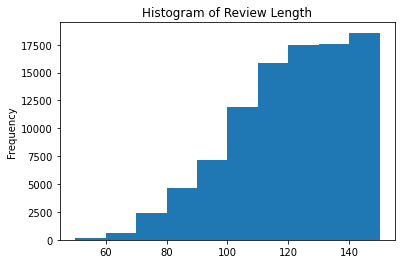

In [36]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of Review Length')

<AxesSubplot:title={'center':'Histogram of Summary Length'}, ylabel='Frequency'>

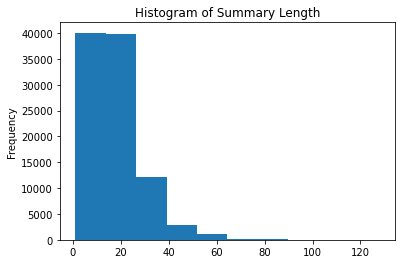

In [37]:
reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

<AxesSubplot:title={'center':'Histogram of Summary Length'}, ylabel='Frequency'>

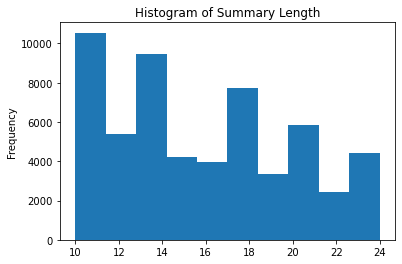

In [38]:
# remove very short and very long summaries
reviews = reviews[(reviews['Summary'].str.len() >= 10) & (reviews['Summary'].str.len() < 25)]

reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

In [54]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive' if x >= 4 else 'neutral' if x == 3 else 'negative')

# Take 1,000 examples from each sentiment group
reviews = reviews.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1000))

<AxesSubplot:>

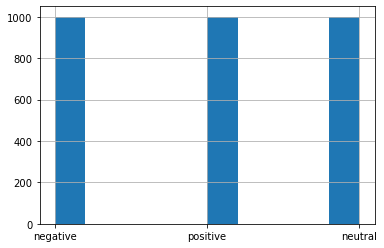

In [174]:
reviews['Sentiment'].hist()

In [55]:
MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

#add two prompts, one for each task
SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARIZE_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'


loading file https://huggingface.co/distilgpt2/resolve/main/vocab.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/55051ac97dcc32f0a736d21a32a4d42b0d9b90f117ca7c38e65038b04bd5c3f5.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
loading file https://huggingface.co/distilgpt2/resolve/main/merges.txt from cache at /Users/sinanozdemir/.cache/huggingface/transformers/9dfb299b74cdf7601ba7cd3a8073dbdac351caec0ed7ab5849b098b3c8ae3d57.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/distilgpt2/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilgpt2/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilgpt2/resolve/main/tokenizer_config.json from cache at None
loading file https://huggingface.co/distilgpt2/resolve/main/tokenizer.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/accb287b5a5396b259738291

In [56]:
reviews['sentiment_text'] = f'{SENTIMENT_PROMPT}\nReview: ' + reviews['Text'] + SENTIMENT_TOKEN +  ' ' + reviews['Sentiment'].astype(str)

reviews['summarize_text'] = f'{SUMMARIZE_PROMPT}\nReview: ' + reviews['Text'] + SUMMARIZE_TOKEN +  ' ' + reviews['Summary'].astype(str)


In [57]:
reviews['sentiment_text'].head(2).tolist()

['Sentiment Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSentiment: negative',
 'Sentiment Task\nReview: Was very excited for these to come, however when I got them. I was NOT happy, not a good flavor or texture.\nSentiment: negative']

In [207]:
print('Sentiment Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSentiment: negative')

Sentiment Task
Review: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.
Sentiment: negative


In [58]:
reviews['summarize_text'].head(2).tolist()

['Summarize Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSummarize: Not bad, but bland',
 'Summarize Task\nReview: Was very excited for these to come, however when I got them. I was NOT happy, not a good flavor or texture.\nSummarize: NOT my favorite']

In [208]:
print('Summarize Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSummarize: Not bad, but bland')

Summarize Task
Review: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.
Summarize: Not bad, but bland


In [59]:
reviews = reviews.sample(frac=1)

training_examples = reviews['summarize_text'].tolist() + reviews['sentiment_text'].tolist()

# 6,000 = 2 prompts per 1,000 examples from the 3 sentiment groups
print(len(training_examples))

6000


In [60]:
multi_task_df = pd.DataFrame({'text': training_examples})

data = Dataset.from_pandas(multi_task_df)

def preprocess(examples):
    return tokenizer(examples['text'], truncation=True)

data = data.map(preprocess, batched=True)

data = data.train_test_split(train_size=.8)

  0%|          | 0/6 [00:00<?, ?ba/s]

In [61]:
model = GPT2LMHeadModel.from_pretrained(MODEL)

loading configuration file https://huggingface.co/distilgpt2/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/f985248d2791fcff97732e4ee263617adec1edb5429a2b8421734c6d14e39bee.422318838d1ec4e061efb4ea29671cb2a044e244dc69229682bebd7cacc81631
Model config GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": tru

In [62]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [63]:
training_args = TrainingArguments(
    output_dir="./gpt2_multitask", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=2, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    logging_steps=50,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    data_collator=data_collator
)

trainer.evaluate()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 32


{'eval_loss': 5.018805980682373,
 'eval_runtime': 56.4334,
 'eval_samples_per_second': 21.264,
 'eval_steps_per_second': 0.673}

In [64]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running training *****
  Num examples = 4800
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 300


Epoch,Training Loss,Validation Loss
1,2.900600,2.751847
2,2.746900,2.701665


The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 32
Saving model checkpoint to ./gpt2_multitask/checkpoint-150
Configuration saved in ./gpt2_multitask/checkpoint-150/config.json
Model weights saved in ./gpt2_multitask/checkpoint-150/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 32
Saving model checkpoint to ./gpt2_multitask/checkpoint-300
Configuration saved in ./gpt2_multitask/checkpoint-300/config.json
Model weights saved in ./gpt2_multitask/checkpoint-300/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./gpt2_multitask/checkpoint-300 (score: 2.7016654014587402).


TrainOutput(global_step=300, training_loss=2.927398376464844, metrics={'train_runtime': 1913.6154, 'train_samples_per_second': 5.017, 'train_steps_per_second': 0.157, 'total_flos': 136927662833664.0, 'train_loss': 2.927398376464844, 'epoch': 2.0})

In [65]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 32


{'eval_loss': 2.7016654014587402,
 'eval_runtime': 54.8621,
 'eval_samples_per_second': 21.873,
 'eval_steps_per_second': 0.693,
 'epoch': 2.0}

In [66]:
trainer.save_model()

Saving model checkpoint to ./gpt2_multitask
Configuration saved in ./gpt2_multitask/config.json
Model weights saved in ./gpt2_multitask/pytorch_model.bin


In [80]:
loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2_multitask')

generator = pipeline('text-generation', model=loaded_model, tokenizer=tokenizer)

loading configuration file ./gpt2_multitask copy/config.json
Model config GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype

In [197]:
text_sample, score, summary = reviews.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]

print(text_sample)
print(score)
print(summary)

num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
neutral
Nature goodness


29

In [198]:
sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text_sample}{SUMMARIZE_TOKEN}'

In [209]:
print(sentiment_text_sample)

Sentiment Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Sentiment:


In [210]:
print(summarize_text_sample)

Summarize Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Summarize:


In [204]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=1, max_length=num_tokens + 1):
    print(generated_text['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 39, but ``max_length`` is set to 30. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


Sentiment Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Sentiment: positive


In [206]:
for generated_text in generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Summarize: Great chips!!  Just the right size
----
Summarize Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Summarize: Great, but not as strong as real
----
Summarize Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Summarize: Geez! Good! Excellent Chips
----


In [216]:
generator = pipeline('text-generation', model=GPT2LMHeadModel.from_pretrained('gpt2'), tokenizer=tokenizer)

loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /Users/sinanozdemir/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-gen

In [217]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=5, max_length=num_tokens + 1):
    print(generated_text['generated_text'])
    print('-------')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 39, but ``max_length`` is set to 30. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


Sentiment Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Sentiment: Would
-------
Sentiment Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Sentiment: Very
-------
Sentiment Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Sentiment: Good
-------
Sentiment Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Sentiment:

-------
Sentiment Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Sentiment: These
-------


In [218]:
for generated_text in generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Summarize:
As with all my orders I always
----
Summarize Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Summarize: Great taste. Very smooth and not overly
----
Summarize Task
Review: Really great tasting chips. I really did not expect them to be as hard as they were. Good if they are cover with a cheese sauce.
Summarize: Definitely a good chip. The chips are
----
